# Minimum viable products: working through full examples.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

## Marginal MNIST:

### Setup

In [3]:
%run models/simple_examples.py
from cgf_network import CGF_ICNN

classifier_ckpt ='./learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'

mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
activity_data, targets = mnist_model.internal_activity_dataset(mnist_model.data_train)[:]

mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_data)

# Need to transform the data
activity_data = mnist_cgf.transform_data(activity_data)

In [4]:
%run change_detection.py
%run cgf_components.py

### Score test

In [16]:
score = ScoreTest(mnist_cgf, 100, 0.5)

### Saddlepoint test

#### Debug 1

In [7]:
saddlepoint = RateFunctionTest(mnist_cgf, 100, 0.5)

[-inf, inf] [-inf, inf]
[-inf, inf] [-inf, inf]
[-inf, inf] [-inf, inf]


KeyboardInterrupt: 

Importance sampling is failing

In [6]:
from scipy.stats import multivariate_normal
n_samples = 1000

def limiting_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28

    thetas, Is = mnist_cgf.dual_opt(mus)
    dets = torch.det(mnist_cgf.hess(thetas))
    
    log_density = (d/2) * np.log(n_samples / (2 * torch.pi)) \
        - 0.5*torch.log(dets) - n_samples*Is

    return torch.exp(log_density).detach()


def within_rate_contour(xs, value):
    """ are the point inside the rate function contour? """
    I_vals = mnist_cgf.dual_function(xs)

    return (I_vals < value).double()

mean = mnist_cgf.jac(torch.zeros(1, 28))[0].detach()
cov = mnist_cgf.hess(torch.zeros(1, 28))[0].detach()
sample_dist = multivariate_normal(mean=mean, cov=(1./n_samples)*cov)
centered_dist = normal_radius_uniform_angle(28, 3)

In [7]:
def empirical_p(threashold):
    func = lambda x: within_rate_contour(x, threashold)
    return importance_sample(func, limiting_density, sample_dist).item()

In [8]:
def limiting_log_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28

    thetas, Is = mnist_cgf.dual_opt(mus)
    logdets = torch.logdet(mnist_cgf.hess(thetas))
    
    log_density = (d/2) * np.log(n_samples / (2 * torch.pi)) \
        - 0.5*logdets - n_samples*Is

    return log_density.detach()


In [45]:
samples = torch.tensor( sample_dist.rvs(1000), dtype = torch.float)

Text(0.5, 1.0, 'log probability under limiting distribution')

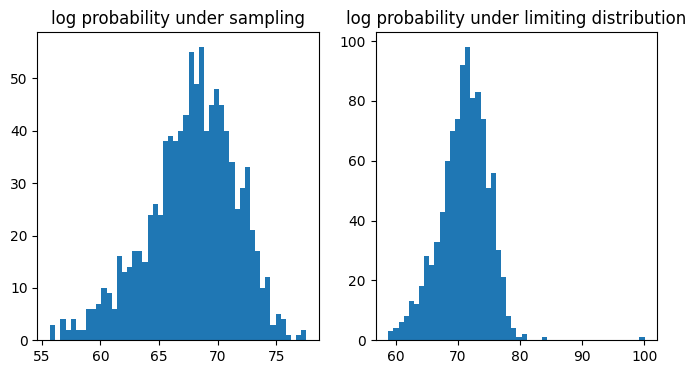

In [59]:
figsize(8, 4)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.hist(sample_dist.logpdf(samples), bins=50);
plt.title('log probability under sampling')

plt.subplot(1,2,2)
plt.hist(limiting_log_density(samples), bins=50);
plt.title('log probability under limiting distribution')

All of the samples are very likely under both distributions. This seems to indicate that both pdfs are highly concnetrated around a shell in the high dimensional space.

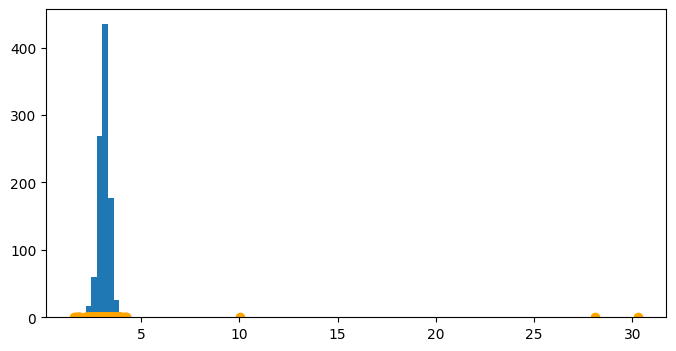

In [75]:
logprobdiff = limiting_log_density(samples) - torch.tensor(sample_dist.logpdf(samples))
plt.hist(logprobdiff, bins=100);
plt.scatter( logprobdiff, np.zeros(1000), c='orange' )

The difference (log importance weight) is mostly reasonalble, but occasionally massive. This would be enough to produce an infinite importance weight

In [89]:
ind = logprobdiff.argmax()
print(limiting_log_density(samples[ind:ind+1]))
print(sample_dist.logpdf(samples[ind:ind+1]))

tensor([99.2144])
69.76425900337262


It's highly probable for both, but massively more for the limiting distribution

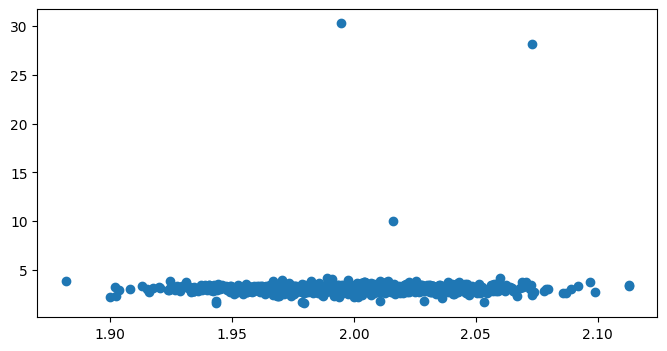

In [85]:
plt.scatter( torch.norm(samples, dim=1), logprobdiff)

It's not an extreme value of the norm either.

In [92]:
important_point = samples[ind:ind+1]

thetas, Is = mnist_cgf.dual_opt(important_point)

In [95]:
torch.logdet(mnist_cgf.hess(thetas))

tensor([-21.7884], grad_fn=<WhereBackward0>)

In [96]:
n_samples * Is

tensor([-17.3420], grad_fn=<MulBackward0>)

In [97]:
limiting_log_density(samples[ind:ind+1])

tensor([99.2144])

In [100]:
d = 28
(d/2) * np.log(n_samples / (2 * torch.pi))

np.float64(70.97829497601909)

In [104]:
(d/2) * np.log(n_samples / (2 * torch.pi)) - 0.5*torch.logdet(mnist_cgf.hess(thetas)) - n_samples * Is

tensor([99.2144], grad_fn=<SubBackward0>)

That's interesting: one major source of instability seems to come from the normalizer, which is large for large values of $d$.


In [227]:
thetas, Is = mnist_cgf.dual_opt(samples)

print('normalizer: ', -(d/2) * np.log((2 * torch.pi)) + (d/2) * np.log( n_samples ))
print('determinant: ', - 0.5 * torch.logdet(mnist_cgf.hess(thetas))[0])
print('rate function: ', -n_samples*Is[0])

normalizer:  70.97829497601907
determinant:  tensor(10.5009, grad_fn=<MulBackward0>)
rate function:  tensor(-12.7793, grad_fn=<MulBackward0>)


Why are the multivariate normal values are so massive?

In [177]:
centered = samples - mean
invcov = torch.linalg.inv( (1./n_samples)*cov)

-d/2 * np.log(2*torch.pi) -0.5*torch.logdet( (1./n_samples)*cov) -0.5 * centered[0] @ invcov @ centered[0]

tensor(66.0259)

In [178]:
sample_dist.logpdf(samples)[0]

np.float64(66.02590349136828)

In [179]:
print('normalizer: ', -d/2 * np.log(2*torch.pi))
print('determinant: ', -0.5*torch.logdet( (1./n_samples)*cov))
print('inner product: ', -0.5 * centered[0] @ invcov @ centered[0])

normalizer:  -25.730278929730837
determinant:  tensor(107.4980)
inner product:  tensor(-15.7418)


In [148]:
print('baseline determinant: ', -0.5*torch.logdet(cov))

baseline determinant:  tensor(10.7894)


We see here that the large log-likelihood values are actually the result of the determinant term. Moreover, this term is large due to the large number of samples.


In [161]:
dets = []
mains = []

sample_nums = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
for sample_num in sample_nums:
    invcov = torch.linalg.inv( (1./sample_num)*cov)
    
    dets.append(-0.5*torch.logdet( (1./sample_num)*cov))
    mains.append(-0.5 * centered[0] @ invcov @ centered[0])

    

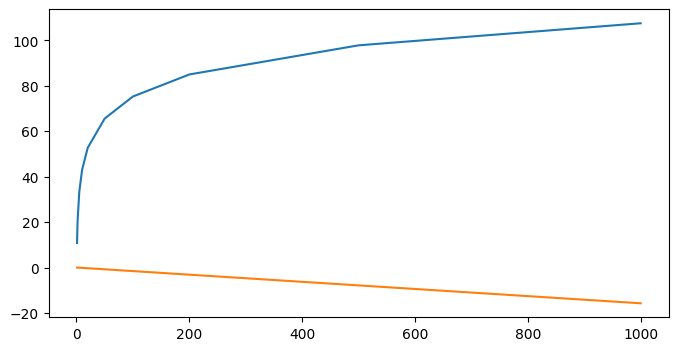

In [162]:
plt.plot(sample_nums, dets)
plt.plot(sample_nums, mains)

Makes sense: the determinant is impacted like the log of a power of the sample number, while the inside of the exponent scales linearly.

Note, however, that the dominance of the determinant term is mostly a function of the high dimensionality. Is this where the sphere size scaling comes into play?

Direct comparison of the two:

__Rate function__

In [228]:
thetas, Is = mnist_cgf.dual_opt(samples)

print('normalizer: ', -(d/2) * np.log((2 * torch.pi)) + (d/2) * np.log( n_samples ))
print('determinant: ', - 0.5 * torch.logdet(mnist_cgf.hess(thetas))[0])
print('rate function: ', -n_samples*Is[0])


normalizer:  70.97829497601907
determinant:  tensor(10.5009, grad_fn=<MulBackward0>)
rate function:  tensor(-12.7793, grad_fn=<MulBackward0>)


__Normal__

In [229]:
print('normalizer: ', -d/2 * np.log(2*torch.pi))
print('determinant: ', -0.5*torch.logdet( (1./n_samples)*cov))
print('inner product: ', -0.5 * centered[0] @ invcov @ centered[0])

normalizer:  -25.730278929730837
determinant:  tensor(107.4980)
inner product:  tensor(-15.7418)


Actually, these share a common source: the large sample number:

In [230]:
(d/2) * np.log( n_samples ) - 0.5 * torch.logdet(cov)

tensor(107.4980)

In [231]:
print('shared normalizer: ', -d/2 * np.log(2*torch.pi))
print('shared sample scaling: ', (d/2) * np.log( n_samples ))

shared normalizer:  -25.730278929730837
shared sample scaling:  96.70857390574992


In [232]:
print('rate determinant: ', - 0.5 * torch.logdet(mnist_cgf.hess(thetas))[0])
print('normal determinant: ', -0.5*torch.logdet(cov))

rate determinant:  tensor(10.5009, grad_fn=<MulBackward0>)
normal determinant:  tensor(10.7894)


In [233]:
print('rate function: ', -n_samples*Is[0])
print('normal inner product: ', -0.5 * centered[0] @ invcov @ centered[0])

rate function:  tensor(-12.7793, grad_fn=<MulBackward0>)
normal inner product:  tensor(-15.7418)


Ok, this analysis seems to indicate that the should be close, as indeed they are for the zeroith sample.

In [234]:
ind = logprobdiff.argmax()

__Abnormal point:__

In [241]:
print('rate determinant: ', - 0.5*torch.logdet(mnist_cgf.hess(thetas))[ind])
print('normal determinant: ', -0.5*torch.logdet(cov))

rate determinant:  tensor(10.9030, grad_fn=<MulBackward0>)
normal determinant:  tensor(10.7894)


In [236]:
print('rate function: ', -n_samples*Is[ind])
print('normal inner product: ', -0.5 * centered[0] @ invcov @ centered[0])

rate function:  tensor(18.1678, grad_fn=<MulBackward0>)
normal inner product:  tensor(-15.7418)


In [202]:
Is[ind]

tensor(-0.0182, grad_fn=<SelectBackward0>)

In [210]:
(Is < 0).sum() 

tensor(2)

In [211]:
limiting_log_density(samples)[(Is < 0)]

tensor([ 83.8279, 100.0490])

The large values happen where rate function < 0... Is this because of a failure in the optimization?

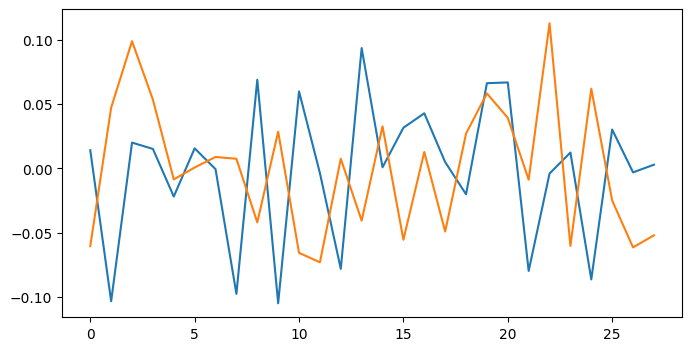

In [237]:
plt.plot(thetas[0])
plt.plot(thetas[ind])

Hard to see much difference between these two.

In [238]:
Is[0]

tensor(0.0128, grad_fn=<SelectBackward0>)

In [239]:
Is[ind]

tensor(-0.0182, grad_fn=<SelectBackward0>)

In [240]:
mnist_cgf.dual_opt(torch.zeros(1, 28))

(tensor([[ 0.0310, -0.6118,  0.1933,  1.2888,  0.7142,  0.5755, -1.9901,  1.4790,
           1.4613,  0.6916,  0.9732, -1.5564,  5.6731, -1.0002,  0.4578,  0.6599,
           0.5901,  0.0486,  1.9333,  0.0066, -1.5986,  1.9843,  1.0630, -0.0406,
           1.5859,  0.9228,  0.0510, -1.3705]]),
 tensor([2.9907], grad_fn=<NegBackward0>))

In [9]:
samples = torch.tensor( sample_dist.rvs(50000), dtype = torch.float)
thetas, Is = mnist_cgf.dual_opt(samples)

In [255]:
from sklearn.manifold import TSNE

tsne = TSNE()

In [256]:
dim_reduced = tsne.fit_transform(thetas)

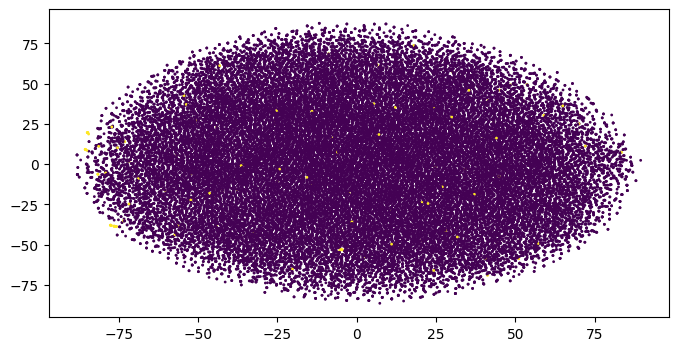

In [259]:
plt.scatter(dim_reduced[:,0], dim_reduced[:,1], s=1, c=(Is < 0))

Not really picked up by the TSNE dimensionality reduction. Many cluster on the left edge, but there are also a lot of points scattered through the bulk of the data.

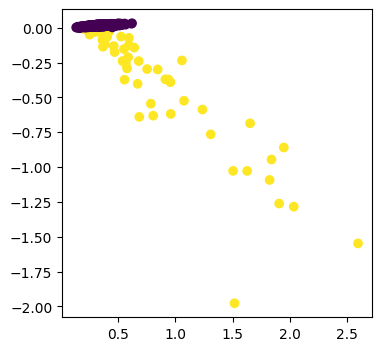

In [263]:
figsize(4,4)
plt.scatter( torch.norm(thetas, dim=1).detach(), Is.detach(), c=(Is < 0))

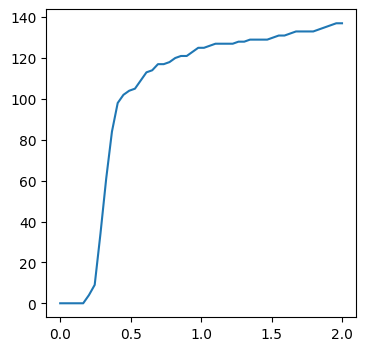

In [266]:
xs = np.linspace(0,2)

num_negative = lambda x: (Is[ torch.norm(thetas, dim=1) < x] < 0).sum()

plt.plot(xs, list(map(num_negative, xs)))

In [268]:
mnist_cgf.dual_opt(torch.zeros([1, 28]))

(tensor([[ 0.0310, -0.6118,  0.1933,  1.2888,  0.7142,  0.5755, -1.9901,  1.4790,
           1.4613,  0.6916,  0.9732, -1.5564,  5.6731, -1.0002,  0.4578,  0.6599,
           0.5901,  0.0486,  1.9333,  0.0066, -1.5986,  1.9843,  1.0630, -0.0406,
           1.5859,  0.9228,  0.0510, -1.3705]]),
 tensor([2.9907], grad_fn=<NegBackward0>))

In [269]:
mnist_cgf.fwd_cpu(torch.zeros([1, 28]))

tensor([[0.0032]], grad_fn=<ToCopyBackward0>)

Legendre:
$$
 I(\theta) = \sup_x{\theta^T x - f(x)}
$$

So, setting $x=0$ is always a possibility, and recovers $f(0) \approx 0$.

Note that $-f(0)$ is a _lower bound_ on the value of $I$, and, therefore, negative values _should_ never be output (at least, no less than the slight deviation).

In [11]:
bothersome_samps = samples[Is < 0]

In [12]:
theta_revised, Is_revised = mnist_cgf.dual_opt(bothersome_samps)

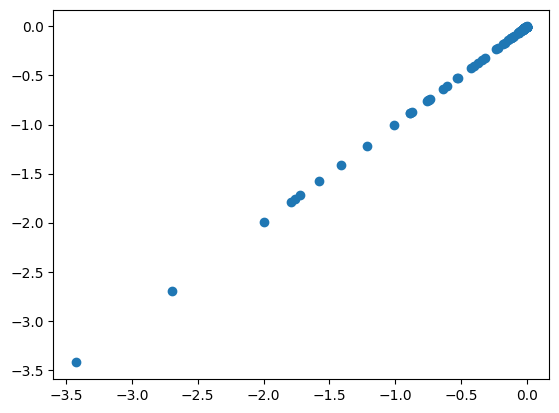

In [13]:
plt.plot(Is[Is<0].detach(), Is_revised.detach(), 'o')

The issue is not with other dependence on other samples

In [26]:
def dual_opt(model, p, optim_method=torch.optim.Adam):
    """
        Solve the dual optimization problem.

        Note that issues will arise if the desired slope is not achieved
        by the CGF
    """
    def to_minimize(x):
        return -(torch.einsum('Nk, Nk -> N', p, x) - model.fwd_cpu(x).squeeze())

    input_val = nn.Parameter(torch.zeros(p.shape))
    optimizer = optim_method((input_val,), lr=1E-3)

    for step in range(500):
        curr_val = optimizer.param_groups[0]['params'][0]
        
        optimizer.zero_grad()
        
        out = to_minimize(curr_val)
        out = out.sum()
        out.backward()
        optimizer.step()

    x_val = optimizer.param_groups[0]['params'][0].data
    
    return x_val, -to_minimize(x_val)

In [27]:
dual_opt(mnist_cgf, bothersome_samps)

(tensor([[-0.0598,  0.0478,  0.0018,  ..., -0.0838, -0.0124,  0.0693],
         [ 0.0398, -0.0370, -0.0278,  ...,  0.0057, -0.0711, -0.0559],
         [ 0.0233, -0.0086, -0.0057,  ...,  0.0172,  0.0322,  0.0380],
         ...,
         [-0.0278, -0.0084, -0.0659,  ..., -0.1622, -0.0614, -0.0274],
         [ 0.0653,  0.0465, -0.1026,  ...,  0.0447, -0.0114,  0.1204],
         [-0.0076, -0.0052, -0.0042,  ..., -0.0113,  0.0283,  0.0051]]),
 tensor([0.0106, 0.0094, 0.0087, 0.0262, 0.0099, 0.0125, 0.0050, 0.0159, 0.0094,
         0.0109, 0.0091, 0.0060, 0.0055, 0.0128, 0.0106, 0.0098, 0.0119, 0.0073,
         0.0133, 0.0124, 0.0158, 0.0079, 0.0140, 0.0171, 0.0191, 0.0060, 0.0113,
         0.0076, 0.0155, 0.0080, 0.0052, 0.0085, 0.0139, 0.0115, 0.0058, 0.0172,
         0.0093, 0.0105, 0.0090, 0.0108, 0.0125, 0.0065, 0.0166, 0.0101, 0.0066,
         0.0083, 0.0119, 0.0108, 0.0158, 0.0098, 0.0102, 0.0130, 0.0093, 0.0106,
         0.0090, 0.0036, 0.0056, 0.0078, 0.0103, 0.0193, 0.0087, 0.0098,

Ok, it looks like the negative values were caused by the learning rate being _too high_, which resulted in unstable oscillations for values that are close to zero.

In [293]:
thetas, Is = dual_opt(mnist_cgf, samples)

In [294]:
(Is > 0).all()

tensor(True)

It is, however, much slower than previously, 

In [52]:
def dual_opt(model, p, optim_method=torch.optim.Adam):
    """
        Solve the dual optimization problem.

        Note that issues will arise if the desired slope is not achieved
        by the CGF
    """
    def to_minimize(x):
        return -(torch.einsum('Nk, Nk -> N', p, x) - model.fwd_cpu(x).squeeze())

    input_val = nn.Parameter(torch.zeros(p.shape))
    optimizer = optim_method((input_val,), lr=1E-3)

    prev_val = input_val.data.clone()
    for step in range(500):
        curr_val = optimizer.param_groups[0]['params'][0]

        # early stopping
        if step > 0 and torch.abs(curr_val.data - prev_val).max() < 1E-4:
            print('early stop', step)
            break
        prev_val = curr_val.data.clone()
        
        optimizer.zero_grad()
        
        out = to_minimize(curr_val)
        out = out.sum()
        out.backward()
        optimizer.step()

    x_val = optimizer.param_groups[0]['params'][0].data
    
    return x_val, -to_minimize(x_val)

In [53]:
dual_opt(mnist_cgf, samples)

(tensor([[-0.0108,  0.0197, -0.0343,  ..., -0.0247,  0.0078,  0.0485],
         [ 0.0318,  0.0393,  0.0535,  ..., -0.0137,  0.0630, -0.0763],
         [ 0.0954,  0.0108,  0.0125,  ..., -0.0674, -0.0278, -0.0816],
         ...,
         [-0.0136,  0.0382, -0.0439,  ..., -0.1289, -0.0045,  0.0654],
         [ 0.0262, -0.0177, -0.0066,  ...,  0.0231, -0.0252, -0.0500],
         [-0.0588,  0.0518, -0.0462,  ..., -0.1220,  0.0281, -0.0143]]),
 tensor([0.0137, 0.0125, 0.0164,  ..., 0.0127, 0.0103, 0.0170],
        grad_fn=<NegBackward0>))

It doesn't seem to be worthwhile using early stopping: it doesn't really come up for reasonable stopping criteria

There were problems with the optimization: too large of a step size

#### Debug 2

In [55]:
%run models/simple_examples.py
%run cgf_network.py


classifier_ckpt ='./learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'

mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
activity_data, targets = mnist_model.internal_activity_dataset(mnist_model.data_train)[:]

mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_data)

# Need to transform the data
activity_data = mnist_cgf.transform_data(activity_data)

In [56]:
saddlepoint = RateFunctionTest(mnist_cgf, 100, 0.5)

[-inf, inf] [-inf, inf]
[-inf, 1] [-inf, 1.0]
[-inf, 1] [-inf, 1.0]
[-inf, 0.25] [-inf, 0.9919308157910146]
[0.125, 0.25] [0.3404870383805788, 0.9919308157910146]
[0.125, 0.1875] [0.3404870383805788, 0.8489647207733622]
[0.125, 0.15625] [0.3404870383805788, 0.6221698545077137]
[0.125, 0.140625] [0.3404870383805788, 0.5141215337461755]
[0.1328125, 0.140625] [0.42558920986222837, 0.5141215337461755]
[0.13671875, 0.140625] [0.47173140152022863, 0.5141215337461755]
[0.138671875, 0.140625] [0.4796976972005026, 0.5141215337461755]
[0.1396484375, 0.140625] [0.4997292908512685, 0.5141215337461755]


Ok, seems to work at first glance.... Quick check on the previous issues:

In [58]:
from scipy.stats import multivariate_normal
n_samples = 1000

def limiting_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28

    thetas, Is = mnist_cgf.dual_opt(mus)
    dets = torch.det(mnist_cgf.hess(thetas))
    
    log_density = (d/2) * np.log(n_samples / (2 * torch.pi)) \
        - 0.5*torch.log(dets) - n_samples*Is

    return torch.exp(log_density).detach()


def within_rate_contour(xs, value):
    """ are the point inside the rate function contour? """
    I_vals = mnist_cgf.dual_function(xs)

    return (I_vals < value).double()

mean = mnist_cgf.jac(torch.zeros(1, 28))[0].detach()
cov = mnist_cgf.hess(torch.zeros(1, 28))[0].detach()
sample_dist = multivariate_normal(mean=mean, cov=(1./n_samples)*cov)
centered_dist = normal_radius_uniform_angle(28, 3)


def empirical_p(threashold):
    func = lambda x: within_rate_contour(x, threashold)
    return importance_sample(func, limiting_density, sample_dist).item()

def limiting_log_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28

    thetas, Is = mnist_cgf.dual_opt(mus)
    logdets = torch.logdet(mnist_cgf.hess(thetas))
    
    log_density = (d/2) * np.log(n_samples / (2 * torch.pi)) \
        - 0.5*logdets - n_samples*Is

    return log_density.detach()


Text(0.5, 1.0, 'log probability under limiting distribution')

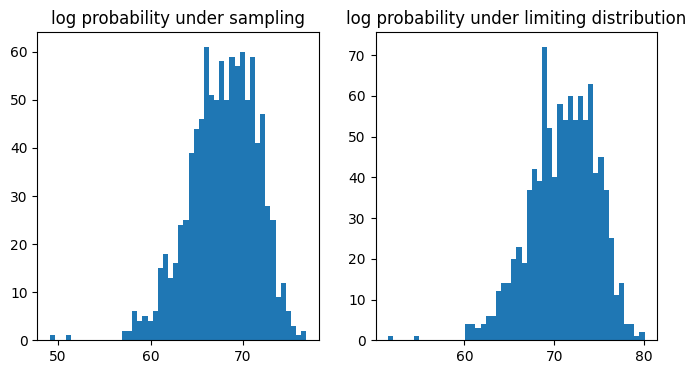

In [59]:
samples = torch.tensor( sample_dist.rvs(1000), dtype = torch.float)

figsize(8, 4)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.hist(sample_dist.logpdf(samples), bins=50);
plt.title('log probability under sampling')

plt.subplot(1,2,2)
plt.hist(limiting_log_density(samples), bins=50);
plt.title('log probability under limiting distribution')

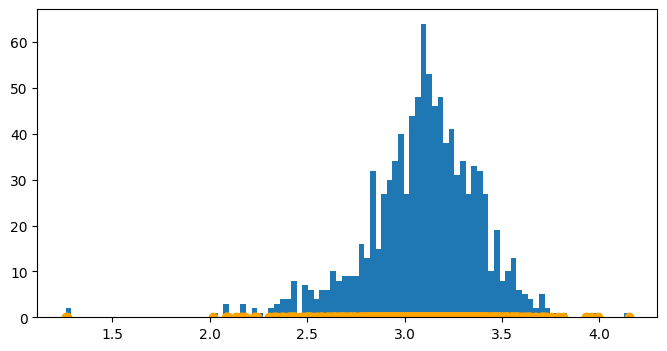

In [60]:
logprobdiff = limiting_log_density(samples) - torch.tensor(sample_dist.logpdf(samples))
plt.hist(logprobdiff, bins=100);
plt.scatter( logprobdiff, np.zeros(1000), c='orange' )

These are all still quite large importance weights ~5-50, which does raise the question of whether we are actually sampling the rate function well.

Or, perhaps the normal-like behavior does dominate, and the sampling is ok.

In [111]:
thetas, Is = mnist_cgf.dual_opt(samples)
logdets = torch.logdet(mnist_cgf.hess(thetas))

#### Testing change-point detection

In [65]:
saddlepoint.threashold

0.139892578125

In [66]:
saddlepoint = RateFunctionTest(mnist_cgf, 100, 0.95)

[-inf, inf] [-inf, inf]
[-inf, 1] [-inf, 1.0]
[-inf, 1] [-inf, 1.0]
[-inf, 0.25] [-inf, 0.9938122853136122]
[0.125, 0.25] [0.33634000325883484, 0.9938122853136122]
[0.1875, 0.25] [0.866657972530567, 0.9938122853136122]
[0.1875, 0.21875] [0.866657972530567, 0.9603644069758075]
[0.203125, 0.21875] [0.924710170312135, 0.9603644069758075]
[0.2109375, 0.21875] [0.9359290177967231, 0.9603644069758075]
[0.2109375, 0.21875] [0.9359290177967231, 0.9603644069758075]
[0.21484375, 0.21875] [0.9499270592924813, 0.9603644069758075]
[0.21484375, 0.21875] [0.9499270592924813, 0.9603644069758075]
[0.21484375, 0.21875] [0.9499270592924813, 0.9603644069758075]
[0.21484375, 0.21875] [0.9499270592924813, 0.9603644069758075]
[0.21484375, 0.21875] [0.9499270592924813, 0.9603644069758075]


In [67]:
saddlepoint.threashold

0.2158203125

Increasing function, larger threashold == more density is contained within.

In [78]:
def sample_subset():
    inds_select = torch.randperm(activity_data.shape[0])[0:100]
    return activity_data[inds_select]

In [91]:
tests = []

for i in range(1000):
    if i % 20 == 0:
        print(i)
    data = sample_subset()
    tests.append(saddlepoint.is_different(data).item())

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


In [93]:
sum(tests) / len(tests)

0.069

Reasonably close to 5%, but a little on the high side. I need to set-up these experiments to run in the background.

Test data change detection:

In [114]:
from torchvision.datasets import MNIST

In [115]:
mnist_test = MNIST('~/Datasets/', download=True, train=False,
                   transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ]))

In [123]:
test_activity, test_targets = mnist_model.internal_activity_dataset(mnist_test)[:]

In [125]:
test_activity = mnist_cgf.transform_data(test_activity)

In [209]:
inds_select = torch.randperm(test_activity.shape[0])[0:100]
saddlepoint.is_different(test_activity[inds_select])

tensor([False])

Train data, biased sampling change detection:

In [201]:
# weighted to choose large target values
weights = np.array(targets)

weights = weights / sum(weights)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_2767/471333017.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  weights = np.array(targets)


In [202]:
samples_ind = np.random.choice(np.arange(targets.shape[0]), size=100, replace=False, p=weights)

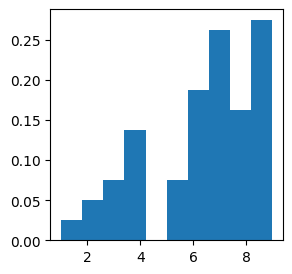

In [203]:
figsize(3,3)
_=plt.hist(targets[samples_ind], bins=10, density=True)

In [204]:
saddlepoint.is_different(activity_data[samples_ind])

tensor([True])

The differences are certainly detected more frequently, but not always detected.

This looks pretty good. We of course have to run longer experiments to get a real answer. How does it compare to the scor function tests?

#### Comparison to score function tests

In [207]:
score = ScoreTest(mnist_cgf, 100, 0.95)

Training set data:

In [212]:
total = 0
for i in range(20):
    inds_select = torch.randperm(activity_data.shape[0])[0:100]
    data = activity_data[inds_select]
    total += int(saddlepoint.is_different(data).item())

print(total/ 20)

0.1


Test set data:

In [214]:
total = 0
for i in range(20):
    inds_select = torch.randperm(test_activity.shape[0])[0:100]
    data = test_activity[inds_select]
    total += int(saddlepoint.is_different(data).item())

print(total/ 20)

0.1


Train data, biased sampling change detection:

In [216]:
total = 0
weights = np.array(targets)
weights = weights / sum(weights)

for i in range(20):
    inds_select = np.random.choice(np.arange(targets.shape[0]), size=100, replace=False, p=weights)
    data = activity_data[inds_select]
    total += int(saddlepoint.is_different(data).item())

print(total/ 20)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_2767/2443266922.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  weights = np.array(targets)


0.85


Overall, these also seem like reasonable test results. Need to run more samples to determine whether there is actually a significant difference between the two tests.

### Bayesian applications of CGF network.

In [222]:
ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'
conditional_mnist = ConditionalCGF.load_from_checkpoint(ckpt,
                     dataset_to_model= mnist_model.internal_activity_dataset(mnist_model.data_train))
                                    


In [224]:
DataLoader(activity_data, batch_size=)

In [227]:
dataset = mnist_model.internal_activity_dataset(mnist_model.data_train)

In [229]:
dataset[:]

(tensor([[ 3.3789, 10.1070,  2.9298,  ..., -0.9327,  1.6541,  0.4650],
         [ 3.8965, -0.8110, -0.8450,  ...,  0.3106,  0.9091,  2.6007],
         [ 6.2431, -0.8634, -0.9719,  ..., -0.9299, -0.6822, -0.5598],
         ...,
         [ 7.0924, -0.9960, -0.9756,  ..., -0.9454,  0.0615,  0.6134],
         [-0.9547,  8.9264, -0.8619,  ..., -0.9976,  5.5175, 16.4374],
         [ 3.5470, -0.7536, -0.9956,  ..., -0.9741, -0.8971,  1.0993]]),
 tensor([9, 1, 1,  ..., 1, 5, 1]))

In [233]:
outs = next(iter(DataLoader(mnist_test, batch_size=len(mnist_test))))

In [236]:
outs2 = next(iter(DataLoader(activity_data, batch_size=len(activity_data))))